![Py4Eng](img/logo.png)

# Profiling
## Yoav Ram

> Premature optimization is the root of all evil - [Donald Knuth](https://dl.acm.org/doi/10.1145/356635.356640)

So how do we optimize our code to make it efficient in terms of running time (fast) and memory?

The first step is to figure out where the performance bottlenecks are.
That is the purpose of **profiling**.

We follow a [blog post](https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025) by Muriz.

## Monte Carlo integration

The algorithm we will attempt to profile and optimize is the [Monte Carlo intergration algorithm](https://en.wikipedia.org/wiki/Monte_Carlo_integration), which we will use to estimate $\pi$ (that's the paradigmatic example of the method).
The area of a full circle with a unit radius is $\pi$. 
Thus if we can compute the area of a quarter of the circle, then we compute $\pi/4$.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
from scipy.integrate import trapezoid

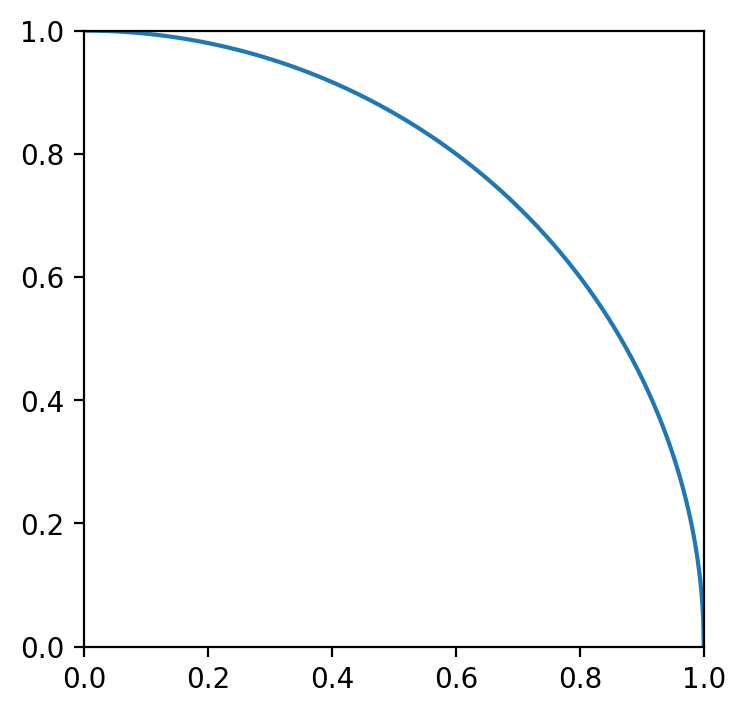

In [2]:
x = np.linspace(0, 1, 1000)
y = (1 - x*x)**0.5

plt.figure(figsize=(4,4))
plt.plot(x, y)
plt.xlim(0, 1)
plt.ylim(0, 1);

How do we compute this area? 
The standard way is using a [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) algorithm.

In [3]:
print(trapezoid(y, x) * 4)

3.1415554110623454


But we can also use Monte Carlo integration.
In this scheme, we uniformly sample $n$ points in the square unit.
These are called "proposal". 
Proposals below the curve (i.e., $x^2+y^2 \le 1$) are _accepted_ and those above the curve are _rejected_.
The area under the curve will then be equal to the fraction of accepted proposal (out of all the proposals) multiplied by the total sampling area (which is 1 for the unit square), providing us with an estimate of $\pi/4$.

Let's start with a simple, non-optimized version of this algorithm. 

In [2]:
from random import random
from math import pow

def estimate_π(n=1e7):
    accepted = 0
    proposals = 0
    while proposals < n:
        x = random()
        y = random()
        if pow(x, 2) + pow(y, 2) <= 1:
            accepted += 1
        proposals += 1
    return 4 * accepted / n

The magic command `%time` is useful for comparing the runtime of different functions (i.e. benchmarking).

In [5]:
%time estimate_π()

CPU times: user 5.76 s, sys: 8.71 ms, total: 5.77 s
Wall time: 5.77 s


3.1412

An even better magic command is `%timeit`, which runs the function multiple times to estimate the mean and standard deviation of the running time.

In [52]:
%timeit estimate_π()

6.01 s ± 183 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


But what takes most of the execution time?

## Python profiler

To answer that, we can use the [Python profiler](https://docs.python.org/3/library/profile.html), which in Jupyter we can run using `%prun` (note that the total running time is  longer now as the profiler adds a computational overhead).

The profiler report gives us the following information for each function:
- `ncalls`: for the number of calls.
- `tottime`: for the total time spent in the given function (and excluding time made in calls to sub-functions)
- `percall`: is the quotient of tottime divided by ncalls
- `cumtime`: is the cumulative time spent in this and all subfunctions (from invocation till exit). This figure is accurate even for recursive functions.
- `percall`: is the quotient of cumtime divided by primitive calls

We run it with `-s tottime` to sort by that column as we want to find out which function takes up the most amount of time. `-l 10` limits the output to just 10 lines.

In [3]:
%prun -s tottime -l 10 estimate_π()

         40000689 function calls (40000672 primitive calls) in 11.932 seconds

   Ordered by: internal time
   List reduced from 169 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    5.422    0.542    9.945    0.994 {built-in method time.sleep}
 20000000    3.133    0.000    3.133    0.000 {built-in method math.pow}
 20000000    2.307    0.000    2.307    0.000 {method 'random' of '_random.Random' objects}
      4/1    0.451    0.113    0.000    0.000 {method 'control' of 'select.kqueue' objects}
        1    0.356    0.356    0.649    0.649 4169839124.py:4(estimate_π)
       13    0.129    0.010    0.239    0.018 socket.py:626(send)
      4/1    0.120    0.030    0.044    0.044 selectors.py:558(select)
        2    0.013    0.006    0.024    0.012 {method '__exit__' of 'sqlite3.Connection' objects}
        4    0.000    0.000    0.000    0.000 attrsettr.py:66(_get_attr_opt)
       60    0.000    0.000    0.000    0.000 

We can see that `random` and `pow` take up most of the running time (`sleep` and some of the other methods are called by the profiler itself).

## Line profiler
Before we continue let's use the [line profiler](https://kernprof.readthedocs.io/) module (`pip install line_profiler`) using the `%lprun` command.

In [5]:
%load_ext line_profiler

In [57]:
%lprun -f estimate_π estimate_π()

Timer unit: 1e-09 s

Total time: 30.2253 s
File: /var/folders/vc/qm7741c57dsg9f7wyrtrdrrm0000gq/T/ipykernel_7615/221964828.py
Function: estimate_π at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def estimate_π(n=1e7):
     5         1          0.0      0.0      0.0      accepted = 0
     6         1       1000.0   1000.0      0.0      proposals = 0
     7  10000001 5385745000.0    538.6     17.8      while proposals < n:
     8  10000000 4548611000.0    454.9     15.0          x = random()
     9  10000000 4396554000.0    439.7     14.5          y = random()
    10  10000000 7858133000.0    785.8     26.0          if pow(x, 2) + pow(y, 2) <= 1:
    11   7855123 3333631000.0    424.4     11.0              accepted += 1
    12  10000000 4702608000.0    470.3     15.6          proposals += 1
    13         1       3000.0   3000.0      0.0      return 4 * accepted / proposals

So 26% of the running time is spent at the `if` statement, 29% in the random number generation; 26% for doing the increments on `accepted` and `proposals`, and 18% in the `while` statement.

## Small improvement
Let's try to optimize by replacing `pow(x,2)` and `pow(y,2)` with `x*x` and `y*y`:

In [7]:
def estimate_π(n=1e7):
    accepted = 0
    proposals = 0
    while proposals < n:
        x = random()
        y = random()
        if x*x + y*y <= 1:
            accepted += 1
        proposals += 1
    return 4 * accepted / n

In [67]:
%timeit estimate_π()

3.52 s ± 228 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We went down from 6s to 3.5s! That's an improvement!

## Generators

Let's try to optimize further by making things more _pythonic_, without resorting to NumPy just yet.

We create a generator for the proposals; another generator for accept/reject booleans; then sum the booleans to get the number of accepted proposals.

The main advantage is that we call `sum` once instead of calling the operator `+=` `n` times.

In [8]:
def estimate_π(n=1e7):
    proposals = ((random(), random()) for _ in range(int(n)))
    accepted = sum(x*x + y*y <= 1 for x, y in proposals)
    return 4 * accepted / n

In [69]:
%timeit estimate_π()

3.91 s ± 85.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This did not improve performance, and maybe even reduced it. 

## NumPy

Our next direction for improvement is using NumPy!

But the real advantage of NumPy is that we can compute all these random numbers in one function call, and then vectorize the rest of the computations--"loose your loops".

In this implementation I separate every operation to it's own line to make better use of the line profiler.

In [15]:
def estimate_π(n=1e7, seed=112323):
    rng = np.random.default_rng(seed)
    proposals = rng.random((int(n), 2))
    squared = proposals*proposals
    squaredsum = squared.sum(axis=1) 
    accepted = squaredsum <= 1
    return 4 * accepted.sum() / n    

In [16]:
%timeit estimate_π()

461 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We got from 3.5s to ~0.5s, which is a great improvment.

Let's test the line profiler:

In [17]:
%lprun -f estimate_π estimate_π()

Timer unit: 1e-09 s

Total time: 0.434963 s
File: /var/folders/vc/qm7741c57dsg9f7wyrtrdrrm0000gq/T/ipykernel_11679/3825458515.py
Function: estimate_π at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def estimate_π(n=1e7, seed=112323):
     2         1      98000.0  98000.0      0.0      rng = np.random.default_rng(seed)
     3         1  107522000.0    1e+08     24.7      proposals = rng.random((int(n), 2))
     4         1   35310000.0    4e+07      8.1      squared = proposals*proposals
     5         1  278473000.0    3e+08     64.0      squaredsum = squared.sum(axis=1) 
     6         1    6291000.0    6e+06      1.4      accepted = squaredsum <= 1
     7         1    7269000.0    7e+06      1.7      return 4 * accepted.sum() / n

So most of the time is spent in `sum` for computing `squaredsum`, which seems a bit strange, let's change it.

In [5]:
def estimate_π(n=1e7, seed=112323):
    rng = np.random.default_rng(seed)
    proposals = rng.random((int(n), 2))
    squared = proposals*proposals
    squaredsum = squared[:,0] + squared[:,1]
    accepted = squaredsum <= 1
    return 4 * accepted.sum() / n    

In [20]:
%timeit estimate_π()

170 ms ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We got an almost 3-fold improvement!

In [21]:
%lprun -f estimate_π estimate_π()

Timer unit: 1e-09 s

Total time: 0.127223 s
File: /var/folders/vc/qm7741c57dsg9f7wyrtrdrrm0000gq/T/ipykernel_11679/2108051525.py
Function: estimate_π at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def estimate_π(n=1e7, seed=112323):
     2         1      97000.0  97000.0      0.1      rng = np.random.default_rng(seed)
     3         1   74113000.0    7e+07     58.3      proposals = rng.random((int(n), 2))
     4         1   25128000.0    3e+07     19.8      squared = proposals*proposals
     5         1   17941000.0    2e+07     14.1      squaredsum = squared[:,0] + squared[:,1]
     6         1    4830000.0    5e+06      3.8      accepted = squaredsum <= 1
     7         1    5114000.0    5e+06      4.0      return 4 * accepted.sum() / n

Now the random number generation is the main culprit, but other then [switching to a different random number generator](https://numpy.org/doc/stable/reference/random/performance.html), there is not much we can do about it, so we are done.

So for the protocol, let's switch to a faster (but not the recommended) RNG, called `SFC64`.

In [25]:
def estimate_π(n=1e7, seed=112323):
    rng = np.random.Generator(np.random.SFC64(seed))
    proposals = rng.random((int(n), 2))
    squared = proposals*proposals
    squaredsum = squared[:,0] + squared[:,1]
    accepted = squaredsum <= 1
    return 4 * accepted.sum() / n    

In [26]:
print("Precision {:.4%}".format(abs(estimate_π() - np.pi)/np.pi))

Precision 0.0015%


In [28]:
%timeit estimate_π()

202 ms ± 5.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So this did not lead to an improvement and if we want a real improvement then we should probably change to a different algorithm such as MCMC or SMC, or use a [deterministic algorithm](https://www.craig-wood.com/nick/articles/pi-chudnovsky/).

## Memory profiling

Next, we will profile the memory of the function using the [memory profiler](https://github.com/pythonprofilers/memory_profiler) module (`pip install memory_profiler`) with the `%memit` magic command.

In [6]:
%load_ext memory_profiler

In [7]:
%memit estimate_π()

peak memory: 518.82 MiB, increment: 391.20 MiB


That's alot of peak memory for computing $\pi$!
Where is all this memory used? We can figure that out with a memory line profiler, but it's a bit more hassle as it doesn't support functions defined in Jupyter, so I have to save the function to a file and load it.

In [2]:
%%file estimate_pi.py
import numpy as np
def estimate_π(n=1e7, seed=112323):
    rng = np.random.default_rng(seed)
    proposals = rng.random((int(n), 2))
    squared = proposals*proposals
    squaredsum = squared[:,0] + squared[:,1]
    accepted = squaredsum <= 1
    return 4 * accepted.sum() / n    

Overwriting estimate_pi.py


In [3]:
from estimate_pi import estimate_π
%mprun -f estimate_π estimate_π()

Filename: /Users/yoavram/Work/Teaching/DataSciPy/sessions/estimate_pi.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     2     71.8 MiB     71.8 MiB           1   def estimate_π(n=1e7, seed=112323):
     3     75.7 MiB      3.9 MiB           1       rng = np.random.default_rng(seed)
     4    228.3 MiB    152.6 MiB           1       proposals = rng.random((int(n), 2))
     5    380.9 MiB    152.6 MiB           1       squared = proposals*proposals
     6    457.2 MiB     76.3 MiB           1       squaredsum = squared[:,0] + squared[:,1]
     7    466.8 MiB      9.5 MiB           1       accepted = squaredsum <= 1
     8    466.8 MiB      0.0 MiB           1       return 4 * accepted.sum() / n

In [4]:
print("Precision {:.2g}".format(abs(estimate_π() - np.pi)/np.pi))

Precision 0.00012


Not surpring: all these float arrays we create - `proposals`, `squared`, `sumsquared` - take up a lot of memory. 
We can deal with it by reusing the same variable name, thereby allowing the garbage collector to collect each array as soon as we don't need it.

We can also change the data type to `float32`, which should save a lot of memory without impacting the accuracy much.

In [27]:
def estimate_π(n=1e7, seed=112323):
    rng = np.random.default_rng(seed)
    proposals = rng.random((int(n), 2), dtype=np.float32)
    proposals = proposals*proposals
    proposals = proposals[:,0] + proposals[:,1]
    accepted = proposals <= 1
    return 4 * accepted.sum() / n    

In [18]:
%memit estimate_π()

peak memory: 293.20 MiB, increment: 0.00 MiB


In [28]:
print("Precision {:.4%}".format(abs(estimate_π() - np.pi)/np.pi))

Precision 0.0057%


So this allowed us to remove the peak memory by about about 50% at some cost to the precision (prevision error went from 0.0015% to 0.0057%).

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)